# 2.3.7 カーネル法を用いたサポートベクタマシン
カーネル法を用いたサポートベクタマシン(SVM)
- 入力空間の超平面のような簡単なモデルでなく、より複雑なモデルを可能にするために線形サポートベクタマシンを拡張したもの

## 2.3.7.1 線形モデルと非線形特徴量
低次元における線形モデルは非常に制約が強い。
- 直線や超平面が柔軟性を制限するため
- 線形モデルを柔軟にする方法の1つが、特徴量を追加すること。
    - 例：入力特徴量の交互作用(積), 多項式を加える。
- make_bolbsのようなデータセットでは直線で分離することができない(線形分離不可)

In [2]:
import mglearn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
# vscode で jupyter notebookを使用したとき図の背景色をデフォルトの白にする。
import matplotlib as mpl
%matplotlib inlデータine
mpl.style.use('default')

Text(0, 0.5, 'Feature 1')

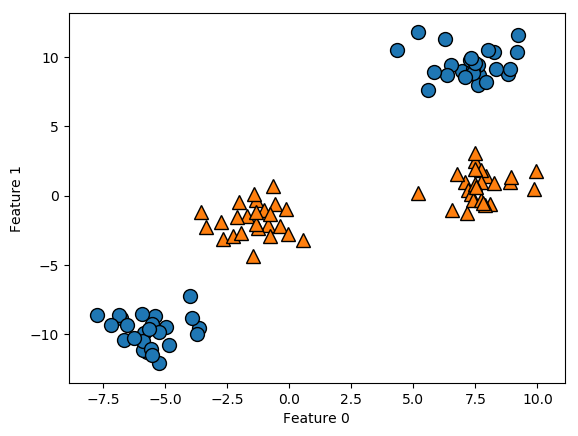

In [4]:
from sklearn.datasets import make_blobs
X, y = make_blobs(centers=4, random_state=8)
y = y % 2
mglearn.discrete_scatter(X[:,0], X[:,1], y)
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')

/home/gpuadmin/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Text(0, 0.5, 'Feature 1')

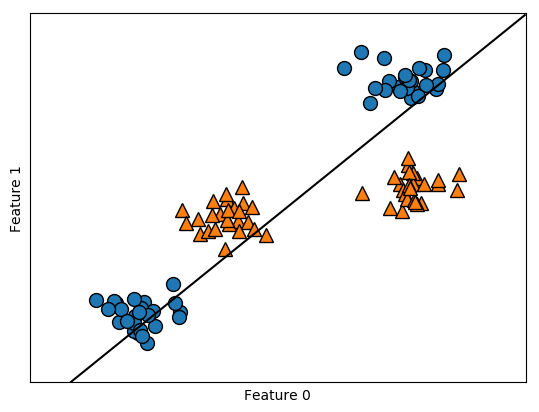

In [5]:
from sklearn.svm import LinearSVC
linear_svm = LinearSVC().fit(X, y)

mglearn.plots.plot_2d_separator(linear_svm, X)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')


【入力特徴量の拡張】
- 2番目の特徴量の2乗を新しい特徴量として加える。
- データポイントは(feature0, feature1, feature1**2)の3次元の点になる。

Text(0.5, 0, 'feature1 ** 2')

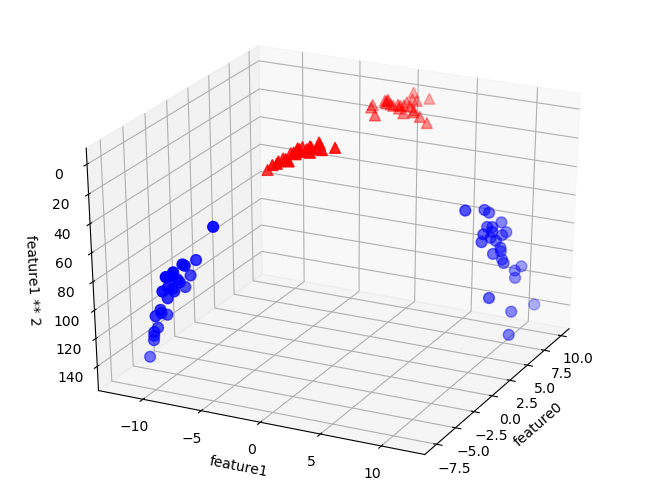

In [11]:
# 2番目の特徴量の2乗を追加
X_new = np.hstack([X, X[:,1:]**2])

from mpl_toolkits.mplot3d import Axes3D, axes3d
figure = plt.figure()
# 3Dで可視化
ax = Axes3D(figure, elev=-152, azim=-26)
# y == 0 の点をプロットしてからy==1の点をプロット
mask = y == 0
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b', cmap=mglearn.cm2, s=60)
# ~a : ビット反転
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^', cmap=mglearn.cm2, s=60)
ax.set_xlabel('feature0')
ax.set_ylabel('feature1')
ax.set_zlabel('feature1 ** 2')

/home/gpuadmin/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Text(0.5, 0, 'feature1 ** 2')

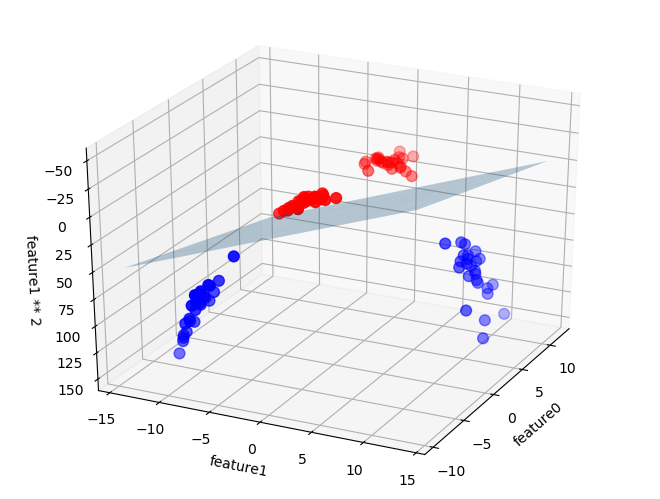

In [15]:
linear_svm_3d = LinearSVC().fit(X_new, y)
coef, intercept = linear_svm_3d.coef_.ravel(), linear_svm_3d.intercept_

# 線形決定境界を描画
figure = plt.figure()
ax = Axes3D(figure, elev=-152, azim=-26)
xx = np.linspace(X_new[:, 0].min()-2, X_new[:, 0].max()+2, 50)
yy = np.linspace(X_new[:, 1].min()-2, X_new[:, 1].max()+2, 50)

XX, YY = np.meshgrid(xx, yy)
ZZ = (coef[0] * XX + coef[1] * YY + intercept) / -coef[2]
ax.plot_surface(XX, YY, ZZ, rstride=8, cstride=8,alpha=0.3)
ax.scatter(X_new[mask,0], X_new[mask,1], X_new[mask, 2], c='b', cmap=mglearn.cm2, s=60)
ax.scatter(X_new[~mask,0], X_new[~mask,1], X_new[~mask, 2], c='r', cmap=mglearn.cm2, s=60)
ax.set_xlabel('feature0')
ax.set_ylabel('feature1')
ax.set_zlabel('feature1 ** 2')

Text(0, 0.5, 'Feature 1')

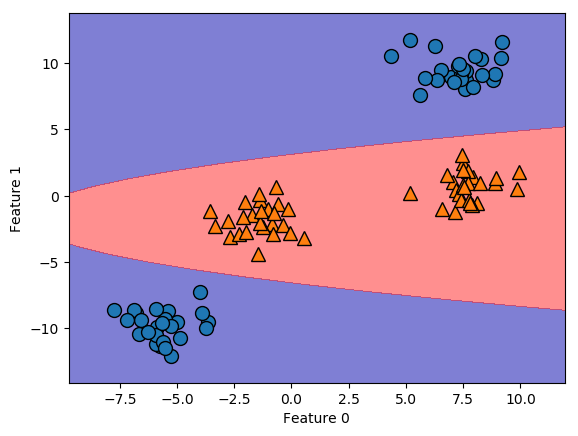

In [16]:
ZZ = YY ** 2
dec = linear_svm_3d.decision_function(np.c_[XX.ravel(), YY.ravel(), ZZ.ravel()])
plt.contourf(XX, YY, dec.reshape(XX.shape), levels=[dec.min(), 0, dec.max()], cmap=mglearn.cm2, alpha=0.5)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')

拡張された3次元空間で、線形SVMで見つかった決定境界が、

もとの2つの特徴量の関数として表示すると、線形SVMモデルが線形ではなく楕円になっている。

## 2.3.7.2 カーネルトリック
- 非線形の特徴量をデータ表現に加えることで、線形モデルがはるかに強力になる。
    - 実際にはどの特徴量を加えたらよいかわからない。
    - たくさんの特徴を加えると計算量が大きくなりすぎる。

カーネルトリック
- 拡張された特徴表現上でのデータポイント間の距離を、実際にデータポイントの拡張を計算せずに直接計算する方法
- 非常に大きくなりうる表現を実際に計算せずに、高次元空間でのクラス分類器を学習させる巧妙な数学的トリック

「高次元空間へのマップ方法」
1. 多項式カーネル(polynomial kernel)
- もとの特徴量の特定の次数までのすべての多項式(feature1 ** 2 * feature2 ** 5など)を計算する
2. 放射基底関数(radial basis funstion:RBF)カーネルとも呼ばれるガウシアンカーネル
- 直観的には、ガウシアンカーネルではすべての次数のすべての多項式を考えるが、次数が高くなるにつれてその特徴量の重要性を小さくしている。

## 2.3.7.3 SVMを理解する
訓練の過程で、SVMは個々のデータポイントが2つのクラスの決定境界を表現するのにどの程度重要を学習する。

**サポートベクタ(support vector)**
- 多くの場合、2つのクラスの境界に位置するごく一部の訓練データポイントだけが決定境界を決定する。
- 決定境界を決定する点がサポートベクタ。(サポートベクタマシンの名前の由来)

「サポートベクタマシンの予測」
- 新しいデータポイントに対して予測を行う場合、サポートベクタとデータポイントとの距離が測定される。
- クラス分類は、このサポートベクタとの距離と訓練課程で学習された個々のサポートベクタの重要性によって決定される。
    - データポイント間の距離は次のように定義されるガウシアンカーネルで測られる。
$$K_{rbf}(x_1,x_2)=\exp(-\gamma||x_1-x_"||^2)$$
- $x_1, x_2$はデータポイント
- $||x_1-x_"||^2$はユークリッド距離
- $\gamma$はガウシアンカーネルの幅を制御するパラメータ

Text(0, 0.5, 'Feature 1')

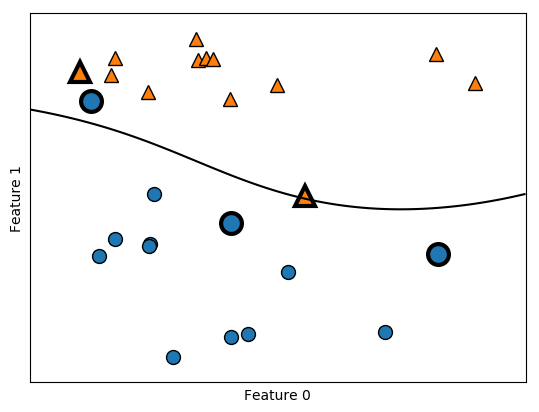

In [20]:
from sklearn.svm import SVC
X,y = mglearn.tools.make_handcrafted_dataset()
svm = SVC(kernel='rbf', C=10, gamma=0.1).fit(X, y)
mglearn.plots.plot_2d_separator(svm, X, eps=.5)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
# サポートベクタをプロットする。
sv = svm.support_vectors_
# サポートベクタのクラスラベルはdual_coef_の正負によって与えられる
sv_labels = svm.dual_coef_.ravel() > 0
mglearn.discrete_scatter(sv[:, 0], sv[:, 1], sv_labels, s=15, markeredgewidth=3)
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')

## 2.3.7.4 SVMパラメータの調整
- gammaパラメータ：ガウシアンカーネルの幅を調整する。
    - 点が近いということを意味するスケールを決定する。
- Cパラメータ：線形モデルと同様の正則化パラメータ
    - 個々のデータポイントの重要度(詳しくはデータポイントのdual_coef_)を制限する。  

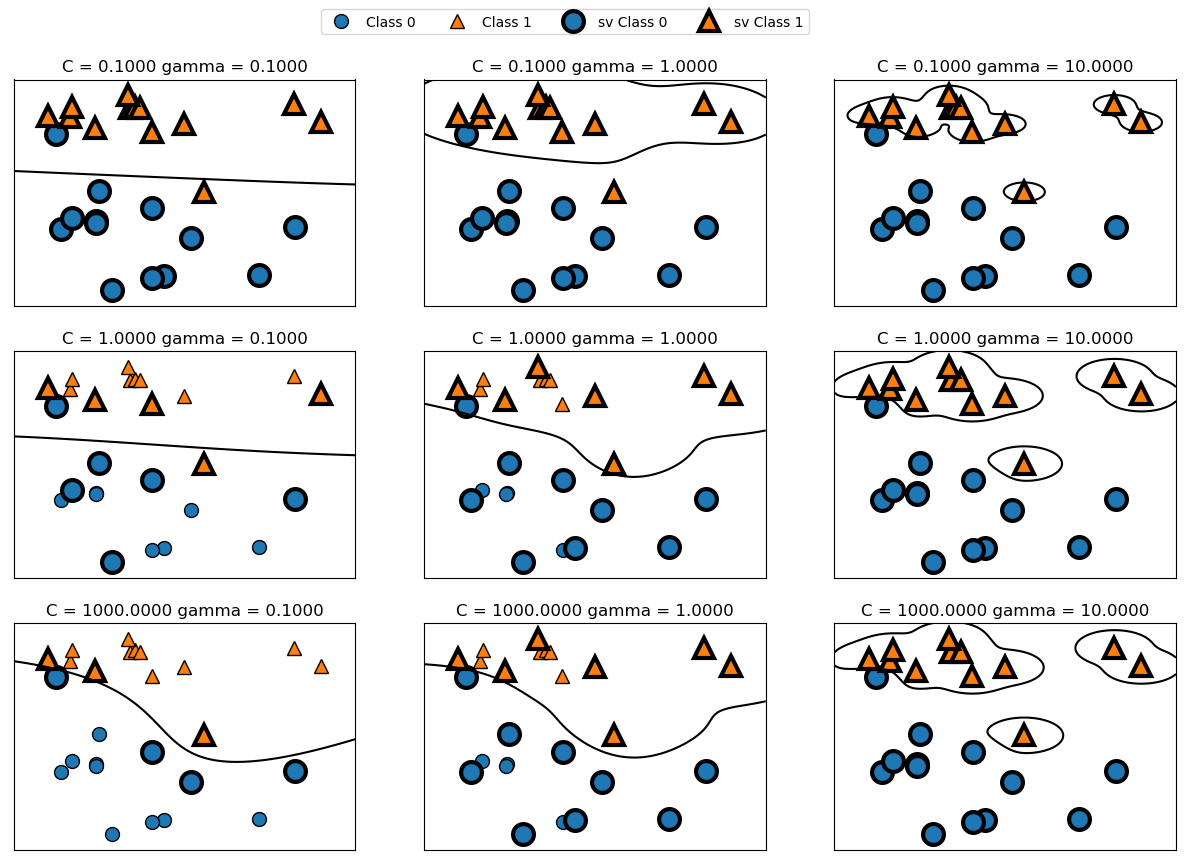

In [21]:
fig, axes = plt.subplots(3,3, figsize=(15,10))
for ax, C in zip(axes, [-1, 0, 3]):
    for a, gamma in zip(ax, range(-1, 2)):
        mglearn.plots.plot_svm(log_C=C, log_gamma=gamma, ax=a)
axes[0,0].legend(['Class 0','Class 1','sv Class 0','sv Class 1'], ncol=4, loc=(.9, 1.2))

「gammaパラメータ」
- gammaが小さいと、ガウシアンカーネルの直径は大きくなり、多くの点を近いと判断するようになる。
    - 左のほうでは決定境界が滑らかになり、右に行くにつれて個々のデータポイントをより重要視するようになる。
- gammaが小さい場合には、決定境界はゆっくりとしか変化せず、モデルの複雑さは小さくなる。
- gammaが大きい場合には、モデルはより複雑になる。

「Cパラメータ」
- 小さいCは制限されたモデルに対応し、個々のデータポイントの与える影響は限定される。
    - 左上の決定境界を見るとほとんど直線であることからもわかる。
    - クラス分類に失敗したデータポイントもあるが、決定境界には全く影響を与えていない。
- Cを大きくすると、データポイントがより強い影響を持つことになり、正しくクラス分類されるように決定境界を曲げている。

In [23]:
# RBFカーネル法を用いたSVMをcancerデータセットに適用
# C=1, gamma=1/n_features
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0
)

svc = SVC()
svc.fit(X_train, y_train)
print('Accuracy on training set:{:.2f}'.format(svc.score(X_train, y_train)))
print('Accuracy on test set:{:.2f}'.format(svc.score(X_test, y_test)))

Accuracy on training set:1.00
Accuracy on test set:0.63
/home/gpuadmin/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


- 訓練セットとテストセットの精度から強く過剰適合していることがわかる。
- パラメータの設定と、データのスケールに敏感である問題がSVMにはある。
- すべての特徴量の変位が同じスケールであることが必要 

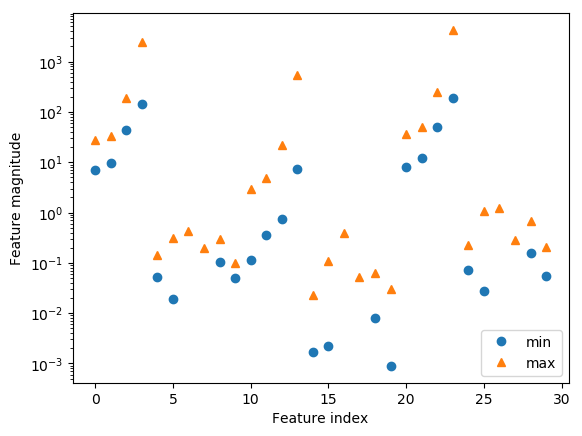

In [24]:
# 個々の特徴量の最大値と最小値を対数でプロットする。
plt.plot(X_train.min(axis=0), 'o', label='min')
plt.plot(X_train.max(axis=0), '^', label='max')
plt.legend(loc=4)
plt.xlabel('Feature index')
plt.ylabel('Feature magnitude')
plt.yscale('log')

- cancerデータセットの特徴量は相互に桁違いにサイズが違うことがわかる。
- カーネル法を用いたSVMでは破壊的な影響をもたらす。

## 2.3.7.5 SVMのためのデータの前処理
よく使われるスケール変換は、すべての特徴量が0から1の間になるようにスケール変換するMinMaxScaler

```3章 教師なし学習と前処理```で詳しく述べる。

In [26]:
# 訓練セットの特徴量ごとに最小値を計算
min_on_training = X_train.min(axis=0)
# 訓練セットの特徴量ごとにレンジ(最大値-最小値)を計算
range_on_training = (X_train - min_on_training).max(axis=0)

# 最小値を引いてレンジで割る
# 個々の特徴量はmin=0, max=1となる。
X_train_scaled = (X_train - min_on_training) / range_on_training
print('Minimum for each feature\n{}'.format(X_train_scaled.min(axis=0)))
print('Maximum for each feature\n{}'.format(X_train_scaled.max(axis=0)))

Minimum for each feature
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
Maximum for each feature
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]


In [27]:
# テストセットに対しても、まったく同じ変換を行う。
# 訓練セットの最小値とレンジを用いる。
X_test_scaled = (X_test - min_on_training)/range_on_training

In [29]:
svc = SVC()
svc.fit(X_train_scaled, y_train)
print('Accuracy on training set:{:.2f}'.format(svc.score(X_train_scaled, y_train)))
print('Accuracy on test set:{:.2f}'.format(svc.score(X_test_scaled, y_test)))

Accuracy on training set:0.95
Accuracy on test set:0.95
/home/gpuadmin/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [30]:
svc = SVC(C=1000)
svc.fit(X_train_scaled, y_train)
print('Accuracy on training set:{:.2f}'.format(svc.score(X_train_scaled, y_train)))
print('Accuracy on test set:{:.2f}'.format(svc.score(X_test_scaled, y_test)))

Accuracy on training set:0.99
Accuracy on test set:0.97
/home/gpuadmin/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


## 2.3.7.6 利点, 欠点, パラメータ
- SVMを用いるとデータにわずかな特徴量しかない場合にも複雑な決定境界を生成することができる。
- 低次元のデータでも高次元のデータでもうまく機能するが、サンプルの個数が大きくなるとうまく機能しない。
    - 10,000サンプルぐらいまではうまく機能するが、100,000サンプルぐらいになると実行時やメモリ使用量の面で難しくなる。
- 特徴量が似た測定器の測定結果(例：カメラのピクセル)のように,同じスケールになる場合にはSVMを試すとよい。

「問題点」
- 注意深くデータの前処理とパラメータ調整を行う必要がある。
- 予測された理由を理解することが難しく、モデルを専門家以外に説明するのが大変

「重要なパラメータ」
- 正則化パラメータC
- カーネルの選択
- カーネル固有のパラメータ
    - RBFカーネルのパラメータは、ガウシアンカーネルの幅の逆数を表すgammaだけ。
    - 他のカーネルもscikit-learnに用意されている。
    - Cとgammaは強く相関をもつため、同時に調整する必要がある。